# Setup

In [158]:
%%capture
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import scvi
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
import scipy
from numpy import var, mean, sqrt
from scipy.stats import ttest_ind
import subprocess

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)

In [3]:
os.getcwd()

'/home/joe/Repositories/M-cells/code/WT_AireKO_Fezf2_thymus'

## data paths

### demeter

In [4]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [5]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## Methods

### effect size

In [157]:
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

### Volcano plot

In [33]:
def volcano_plot(de, highlight_genes, label_genes=[], highlight_color="red", save_path=None):
    ax = sns.scatterplot(
        x=de.lfc_mean,
        y=de.bayes_factor,
        linewidth=0,
        s=5,
        color="lightgrey",
    )
    ax.grid(False)
    ax.set(xlabel='lfc_mean')
    sns.scatterplot(
        x=de[de.index.isin(highlight_genes)].lfc_mean,
        y=de[de.index.isin(highlight_genes)].bayes_factor,
        linewidth=0,
        s=5,
        color=highlight_color,
    )
    plt.axhline(y=2, color="black", linestyle="dashed")
    #plt.axvline(x=-1, color="black", linestyle="dashed")
    plt.axvline(x=1, color="black", linestyle="dashed")
    for gene in label_genes:
        plt.text(
            de[de.index == gene].lfc_mean,
            de[de.index == gene].bayes_factor,
            s=gene,
            color="tab:blue",
            fontdict={"fontsize":12},
        )
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

### immgen cosine similarity

In [39]:
def get_immgen_similarity_signatures(save_path):
    if save_path[-1] == "/":
        save_path = save_path[:-1]
    # Download data from github to datasets folder
    if not os.path.exists(f"{save_path}/immgen"):
        subprocess.run(["wget", "-P", f"{save_path}/",
                        "https://gist.github.com/vasilisNt/5e23eeefc188e1e772f428c74ef43277/raw/67f83d282b0b2180a8eeff74edf079d8826b12ba/immgen.tar.gz"],
                       stdout=subprocess.DEVNULL,
                       stderr=subprocess.DEVNULL,)
        subprocess.run(["tar", "-xzf", f"{save_path}/immgen.tar.gz", "-C", f"{save_path}/"])
        subprocess.run(["rm", "-rf", f"{save_path}/immgen.tar.gz"])

    # Import immgen data
    immgen = pd.read_csv(f"{save_path}/immgen/Immgen_expression.txt", sep='\t', index_col=0)
    probes = pd.read_csv(f"{save_path}/immgen/Immgen_probes.txt", sep='\t', index_col=0, header=None)
    g2n = pd.read_csv(f"{save_path}/immgen/mart_export.txt", sep='\t', )

    # create DataFrame with signatures
    probes = probes.join(g2n.set_index('Gene stable ID')['Gene name'], on=1)
    probes.columns = ['gene_id', 'gene_name']
    immgen = immgen.join(probes['gene_name']).set_index('gene_name')
    immgen = immgen.groupby(immgen.index).aggregate('sum')

    # Save signatures csv
    immgen.to_csv(f"{save_path}/immgen/immgen_signatures.csv")

    return immgen

In [46]:
# adata must have log normalized counts in its raw attribute
# signatures must be a gene (row) by cell type (column) dataframe with average log normalized counts
def cell_type_cosine_similarity(adata, signatures, scale=True, label="cosine_similarity"):
    # Raw attribute contains the log-normalized counts
    cell_data = pd.DataFrame(adata.raw.X.toarray(), columns=adata.raw.var_names, index=adata.obs.index).T
    cell_data = cell_data[cell_data.index.isin(adata.var_names)]
    cell_data = cell_data / cell_data.sum(axis=0) # Normalize per cell expression to sum to 1
    all_df = cell_data.join(signatures, how="inner") # Join with gene x cell type signature matrix so that only shared genes are kept
    all_df = all_df / all_df.sum(axis=0) # Normalize per cell expression to sum to 1
    print(f"Number of genes used for cosine similarity calculations: {len(all_df)}")
    # Calculate cosine similarity of single cells to each cell type
    sim = cosine_similarity(
        all_df[all_df.columns[:cell_data.shape[1]]].values.T, # Single-cell expression data
        all_df[all_df.columns[cell_data.shape[1]:]].values.T # Cell type gene signature expression data
    )

    # Create dataframe with per cell similarity scores for each cell type
    similarity = pd.DataFrame(
        sim, 
        columns=all_df.columns[cell_data.shape[1]:],
        index=all_df.columns[:cell_data.shape[1]]
    )
    if scale:
        # Scale similarity scores by cell
        scaler = StandardScaler()
        minmax_scale = scaler.fit(similarity.T)
        x_minmax = minmax_scale.transform(similarity.T).T
        scale_by_row = pd.DataFrame(x_minmax)
        
        # Add cosine similarity scores to adata obs
        scale_by_row.index = similarity.index
        scale_by_row.columns = similarity.columns + "_" + label
        for column in scale_by_row.columns:
            if column in adata.obs.columns:
                del adata.obs[column]
        adata.obs = adata.obs.join(scale_by_row)
    else:
        similarity.columns = similarity.columns + "_" + label
        for column in similarity.columns:
            if column in adata.obs.columns:
                del adata.obs[column]
        adata.obs = adata.obs.join(similarity)
    
    return adata

## import data

In [6]:
adata = sc.read(f"{processedDataPath}/M_cell/h5ad_files/combined_WT_fezf2KO_aireKO_all_genes.h5ad")
model = scvi.model.SCVI.load(f"{processedDataPath}/M_cell/scVI_models/combined_WT_fezf2KO_aireKO_all_genes", adata=adata)

INFO     File /mnt/iacchus/joe/processed_data//M_cell/scVI_models/combined_WT_fezf2KO_aireKO_all_genes/model.pt    
         already downloaded                                                                                        


# DE markers

## Late Aire

In [8]:
lateAireDE = model.differential_expression(
    adata=adata[adata.obs.genotype == "WT"],
    groupby="cell_type",
    group1="Late Aire",
)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
DE...: 100%|██████████| 1/1 [00:07<00:00,  7.41s/it]


In [9]:
filteredLateAireDE = lateAireDE[lateAireDE.bayes_factor > 2].copy()
filteredLateAireDE = filteredLateAireDE[filteredLateAireDE.lfc_mean > 1]
filteredLateAireDE = filteredLateAireDE[filteredLateAireDE.non_zeros_proportion1 > 0.05]

In [10]:
# Filter genes with low average normalized expression
expressionFiltered = pd.DataFrame(
    pd.DataFrame(
        adata[:, filteredLateAireDE.index].layers["scVI_normalized"],
        columns=filteredLateAireDE.index
    ).quantile(0.99)
)
expressionFiltered = expressionFiltered[expressionFiltered[0.99] > 1]
filteredLateAireDE = filteredLateAireDE[filteredLateAireDE.index.isin(expressionFiltered.index)]

In [11]:
lateAireDE.to_csv("../../analysis/marker_genes_DE/late_Aire_all_genes.csv")
filteredLateAireDE.to_csv("../../analysis/marker_genes_DE/late_Aire_filtered_markers.csv")

In [68]:
[i for i in filteredLateAireDE.index if "H2" in i]

['H2-Eb2', 'H2-Ob', 'H2-Q10', 'H2-Oa', 'H2-M2', 'H2-Q2']

In [20]:
filteredLateAireDE.head(25)

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Fabp9,0.9690,0.0310,3.442277,0.000326,0.000076,0.0,0.25,3.638608,4.011539,2.727110,...,7.207199,1.343616,0.367528,0.119938,4.233203,0.755749,True,Late Aire vs Rest,Late Aire,Rest
Ces2c,0.9630,0.0370,3.259135,0.000143,0.000030,0.0,0.25,2.882811,2.945187,2.269751,...,2.205961,0.448406,0.519708,0.173235,1.443848,0.254237,True,Late Aire vs Rest,Late Aire,Rest
Il12a,0.9620,0.0380,3.231428,0.000292,0.000054,0.0,0.25,3.020069,2.964895,2.093868,...,4.107272,0.715289,0.567476,0.217611,2.597095,0.385099,True,Late Aire vs Rest,Late Aire,Rest
Nos2,0.9604,0.0396,3.188521,0.000477,0.000087,0.0,0.25,2.907770,2.840875,2.111715,...,7.450998,1.200567,0.790394,0.301164,4.776986,0.681060,True,Late Aire vs Rest,Late Aire,Rest
Cyp2a5,0.9604,0.0396,3.188521,0.000337,0.000294,0.0,0.25,1.905561,2.175759,3.061742,...,4.214046,5.847253,0.400679,0.323817,2.674058,3.480124,True,Late Aire vs Rest,Late Aire,Rest
Ly6i,0.9596,0.0404,3.167687,0.000166,0.000035,0.0,0.25,2.824755,2.839859,2.138304,...,2.407208,0.570133,0.387888,0.168891,1.527532,0.327738,True,Late Aire vs Rest,Late Aire,Rest
Acsm2,0.9594,0.0406,3.162540,0.000031,0.000005,0.0,0.25,3.129616,2.860496,2.621001,...,0.315583,0.048487,0.063691,0.020093,0.195032,0.025088,True,Late Aire vs Rest,Late Aire,Rest
Smtnl1,0.9592,0.0408,3.157417,0.000344,0.000056,0.0,0.25,3.247239,3.136974,2.273345,...,4.952999,0.635300,0.576090,0.152133,3.171910,0.345221,True,Late Aire vs Rest,Late Aire,Rest
Resp18,0.9582,0.0418,3.132160,0.000491,0.000114,0.0,0.25,2.722915,2.733577,2.366560,...,8.749865,1.797547,0.589663,0.267184,5.681382,1.102462,True,Late Aire vs Rest,Late Aire,Rest
Apoc2,0.9578,0.0422,3.122219,0.000065,0.000027,0.0,0.25,1.566774,1.290701,6.329399,...,1.992171,0.629869,0.080136,0.033514,1.161971,0.320986,True,Late Aire vs Rest,Late Aire,Rest


### volcano plot

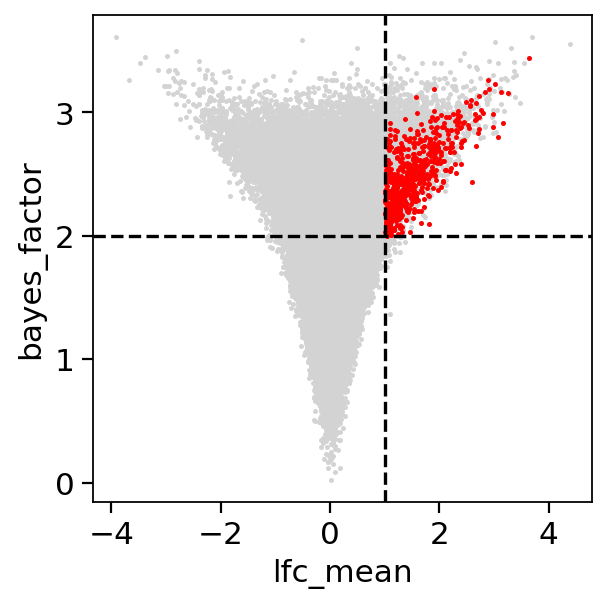

In [184]:
volcano_plot(
    lateAireDE,
    filteredLateAireDE.index,
    #label_genes=["Il12a", "Nos2", "Ly6i", "Irf8", "Cd80", 'H2-Oa', 'H2-Ob'],
    save_path="../../analysis/Paper figs/2 (AireKO)/2F_Late_Aire_DE.pdf"
)

### late aire expression across genotypes

Il12a:	Aire KO->WT	p = 69.52452668615012	d = 0.468
Il12a:	Fezf2_KO->WT	p = 0.696552963602101	d = -0.049

Nos2:	Aire KO->WT	p = 67.34975661925296	d = -0.46
Nos2:	Fezf2_KO->WT	p = 293.1879730046408	d = -1.513

Ly6i:	Aire KO->WT	p = 19.79447011569049	d = 0.243
Ly6i:	Fezf2_KO->WT	p = 192.10403243871087	d = -1.192

Cd80:	Aire KO->WT	p = 179.90535560657443	d = -0.773
Cd80:	Fezf2_KO->WT	p = 9.000212481073042	d = 0.235

Irf8:	Aire KO->WT	p = inf	d = 1.565
Irf8:	Fezf2_KO->WT	p = 123.30149308171104	d = -0.936

H2-Oa:	Aire KO->WT	p = 265.8467085071934	d = 0.956
H2-Oa:	Fezf2_KO->WT	p = 49.039405480302804	d = -0.576

H2-Ob:	Aire KO->WT	p = inf	d = 1.457
H2-Ob:	Fezf2_KO->WT	p = 0.2214765692216062	d = -0.02



/tmp/ipykernel_781022/922988528.py:14: RuntimeWarning: divide by zero encountered in log10
  print(f"{column}:\tAire KO->WT\tp = {-np.log10(p)}\td = {round(d, 3)}")


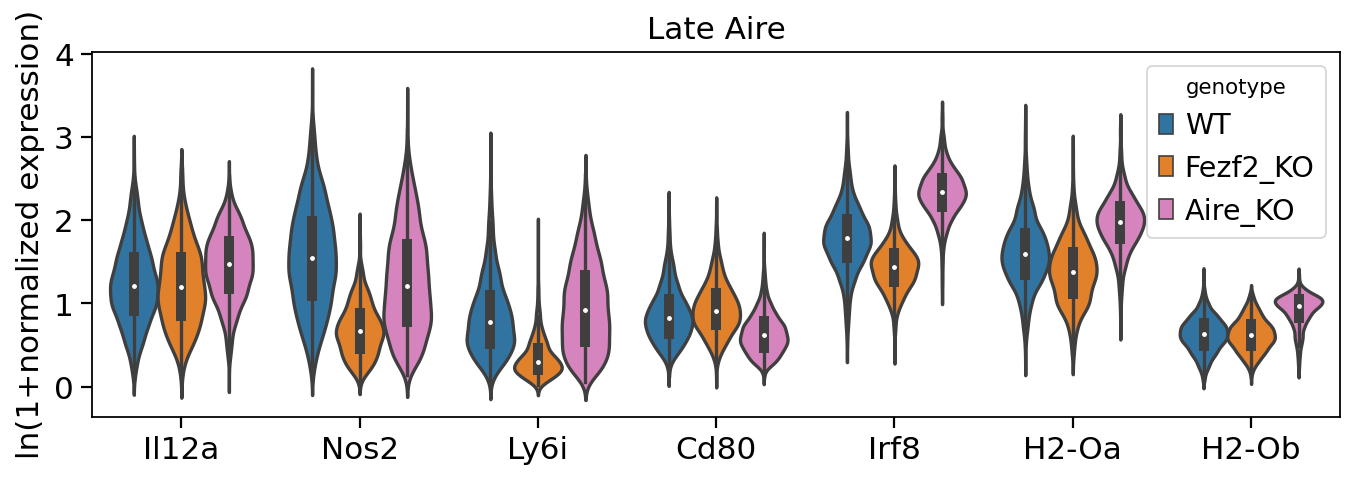

In [182]:
geneList = ["Il12a", "Nos2", "Ly6i", "Cd80", "Irf8", 'H2-Oa', 'H2-Ob']
plotData = pd.DataFrame(
    adata[adata.obs.cell_type == "Late Aire", geneList].layers["scVI_normalized"],
    index = adata[adata.obs.cell_type == "Late Aire", geneList].obs.index,
    columns = adata[adata.obs.cell_type == "Late Aire", geneList].var_names
)
plotData = np.log1p(plotData)

plotData["genotype"] = adata[adata.obs.cell_type == "Late Aire", geneList].obs.genotype
for column in plotData:
    if column != "genotype":
        t,p = ttest_ind(plotData[plotData.genotype == "Aire_KO"][column], plotData[plotData.genotype == "WT"][column])
        d=cohen_d(plotData[plotData.genotype == "Aire_KO"][column], plotData[plotData.genotype == "WT"][column])
        print(f"{column}:\tAire KO->WT\tp = {-np.log10(p)}\td = {round(d, 3)}")
        t,p = ttest_ind(plotData[plotData.genotype == "Fezf2_KO"][column], plotData[plotData.genotype == "WT"][column])
        d=cohen_d(plotData[plotData.genotype == "Fezf2_KO"][column], plotData[plotData.genotype == "WT"][column])
        print(f"{column}:\tFezf2_KO->WT\tp = {-np.log10(p)}\td = {round(d, 3)}")
        print()
del plotData["genotype"]

plotData = plotData.melt()
plotData["genotype"] = list(adata[adata.obs.cell_type == "Late Aire", geneList].obs.genotype)*len(geneList)

plt.figure(figsize=(10,3))
ax = sns.violinplot(
    plotData,
    x="variable",
    y="value",
    hue="genotype",
    scale="width",
    palette=["tab:blue", "tab:orange", "tab:pink"]
)
plt.ylabel("ln(1+normalized expression)")
plt.xlabel("")
plt.title("Late Aire")
ax.grid(False)